# A/B-тестирование для проверки динамики платежной активности

# Содержание

**Часть 0: Описание задачи
<br>
<br>
Часть 1: Проверка корректности данных
<br>
<br>
Часть 2: Анализ равномерности и валидности распределения юзеров по группам
<br>
<br>
Часть 3: Анализ результатов эксперимента
<br>
<br>
Часть 4: Заключение**

# Часть 0: Описание задачи

Был запущен сплит-тест (а/б-тест), направленный на улучшение платежной активности пользователей. Вам дан датасет с транзакциями пользователей до и во время теста в контрольной и тестовых группах
<br>
<br>
1. Какие вы можете сделать выводы? Какая группа показала лучшие результаты?
<br>
2. Можем ли мы как-то оценить из этих данных равномерность и валидность распределения юзеров по разным группам?
<br>
3. Если не ограничиваться теми данными, которые приведены в рамках этого задания, что ещё вы бы посчитали для оценки результатов групп?
<br>
<br>
Описание данных:
<br>
<br>
В таблице users_ приведена информация о том, какой юзер в какой момент времени попал в а/б тест:
<br>
tag - лэйбл группы (control - контрольная, остальные - тестовые)
<br>
ts - время, когда впервые был выдан tag. То есть, все события до наступления времени ts происходили с юзером до попадания в а/б тест
<br>
user_uid - внутренний id юзера (для матчинга со второй таблицей)
<br>
registration_time - время регистрации пользователя в сервисе
<br>
conv_ts - время совершения первой покупки пользователем в сервисе
<br>
<br>
В таблице purchases_ приведена информация о транзакциях пользователей из таблицы users_ до и во время а/б теста:
<br>
user_uid - внутренний id юзера (для матчинга со второй таблицей)
<br>
time - время совершения транзакции
<br>
consumption_mode - вид потребления контента (dto - единица контента куплена навсегда, rent - единица контента взята в аренду, subscription - оформлена подписка)
<br>
element_uid - уникальный id единицы контента или подписки
<br>
price - цена (преобразованная)
<br>
<br>
Значения в полях price и всех полях, указывающих на время - преобразованы. Это значит, что значение в таблице не настоящее, но является линейным преобразованием реального значения, где ко всем значениям одного поля применено одно и то же преобразование - между ними сохранено отношение порядка. Ко всем полям, обозначающим время, применено одно и то же преобразование.

# Часть 1: Проверка корректности данных

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
users = pd.read_csv('users_.csv')
users

,tag,ts,user_uid,registration_time,conv_ts
0,test4,30152.843868,001885550d78efd82c0f5cc02ad3369a,27410.154590,29485.529691
1,control,30133.146255,deb7d0e9bf9813d4f21b579d3703c6e1,27410.171795,27632.424734
2,test1,30140.447675,32095e22f853e595a0f407ad081e7da8,27410.217536,27414.028899
3,control,30136.790772,9932d33f40ad07d7f3ddb7c6aee1bc60,27410.227367,27573.751226
4,test2,30150.339264,4a122db1ad0214e969df154d2dbb4622,27410.230786,29545.833019
...,...,...,...,...,...
696977,test3,30135.048875,e10d8044e619248ed68e54bc9f78efa9,27410.028612,27640.573832
696978,test2,30144.864583,75c4da27fde4db78cf7e92e1847d1661,27410.037686,29293.210971
696979,test4,30157.801078,d679d86c76c03f86e1459bde6b582664,27410.050534,29633.843281
696980,test4,30140.139148,ca7d91f45bcc7eed9402a781e48cd6f5,27410.114820,27448.255112


In [389]:
users.ts.nunique()

696500

In [390]:
pd.to_datetime(users['ts']).nunique()

27

Переводить данные в формат времени не имеет смысла - теряются уникальные значения

In [391]:
users.dtypes

tag                   object
ts                   float64
user_uid              object
registration_time    float64
conv_ts              float64
dtype: object

In [392]:
users.nunique()

tag                       5
ts                   696500
user_uid             694819
registration_time    690641
conv_ts                2893
dtype: int64

In [393]:
users.groupby('user_uid').agg({'tag': 'nunique'}).tag.value_counts()

1    693358
2      1437
3        23
4         1
Name: tag, dtype: int64

У нас есть 1461 пользователь, которым одновременно присвоено 2, 3 и даже 4 тэга. Это пересечение, таких пользователей надо удалить из датасета. Они в сумме занимают 0.2% от общего числа юзеров.

In [4]:
with_1_tag = []
[with_1_tag.append(i) for i in users.groupby('user_uid', as_index=False).agg({'tag': 'nunique'}).query("tag != 1").user_uid]
len(with_1_tag)

1461

In [5]:
users = users.query("user_uid not in @with_1_tag")
users.shape

(694011, 5)

In [396]:
users.nunique()

tag                       5
ts                   693534
user_uid             693358
registration_time    689211
conv_ts                2893
dtype: int64

In [168]:
users.query("registration_time > ts").shape

(141, 5)

В датасете 141 человек (0.02% от всех пользователей), у которого дата регистрации меньше даты присвоения тэга. Исключим их

In [6]:
ts_before_reg = []
[ts_before_reg.append(i) for i in users.query("registration_time > ts").user_uid]
users = users.query("user_uid not in @ts_before_reg")

In [62]:
users.shape

(693870, 5)

In [400]:
users.groupby('user_uid').agg({'registration_time': 'nunique'}).registration_time.value_counts()

1    692744
0       473
Name: registration_time, dtype: int64

In [401]:
users.groupby('user_uid').agg({'ts': 'nunique'}).ts.value_counts()

1    692582
2       617
3        18
Name: ts, dtype: int64

In [402]:
users.groupby('user_uid').agg({'conv_ts': 'nunique'}).conv_ts.value_counts()

1    692975
0       242
Name: conv_ts, dtype: int64

В выборке есть юзеры, по которым произошли дубли - их 635 (0.09% от выборки). Им присваивались одни и те же тэги, но более одного раза в разные даты. Удалим их

In [7]:
duplicates_list = []
[duplicates_list.append(i) for i in users.groupby('user_uid', as_index=False).agg({'ts': 'nunique'}).query("ts > 1").user_uid]
users = users.query("user_uid not in @duplicates_list")

In [64]:
users.shape

(692582, 5)

In [405]:
users.nunique()

tag                       5
ts                   692105
user_uid             692582
registration_time    688443
conv_ts                2887
dtype: int64

Предобработка датасета users закончена. Перейдем к таблице purchases

In [8]:
purchases = pd.read_csv('purchases_.csv')
purchases

,user_uid,time,consumption_mode,element_uid,price
0,d60a7038c7b7e99146ffea6f6535862b,30158.645112,dto,2ba66ac9785731da67b2b6155efaca5c,44.470588
1,0906074e1a1a9229b5e749860b646962,30158.645015,dto,e56d422275d90c96762f81db85d80f3d,38.588235
2,efb6eeca3135d573739e5c5d4dbce330,30158.644990,dto,544f7dd31bd61558c9c738adcff6aafa,50.352941
3,ccd658e372645c991ce49b444839712f,30158.644789,dto,8256d0fc7b25382aacfec0066e39cde3,44.470588
4,89ae5e43ff7b89f9d262d507dedc1760,30158.644200,dto,a579f32b5c116624cc661c9d3b96d5e5,44.470588
...,...,...,...,...,...
663844,b95eb8746f20dba6ddc804a382b0763a,30106.491242,rent,f17e9ea5412551ddb4b258595413f98c,26.823529
663845,facc4c49dd6e6bccd77be41845297f2a,30106.491145,dto,0ccd083bb2e44eeed4d6e2b6ca86a480,44.470588
663846,f81a8bf7f6d136108da82dcf0b8e1141,30106.491129,rent,7bbdee0cb298b62ab4766241d2fb477d,26.823529
663847,0ffbe5d7a89472510b757f4c674c3b4d,30106.491029,dto,5aa724c0393087cde3a18c625b310645,21.058824


In [5]:
purchases.dtypes

user_uid             object
time                float64
consumption_mode     object
element_uid          object
price               float64
dtype: object

In [407]:
purchases.isna().sum()

user_uid            0
time                0
consumption_mode    0
element_uid         0
price               0
dtype: int64

In [408]:
purchases.drop_duplicates().shape

(663849, 5)

Таблица purchases не содержит пропусков и дубликатов, форматы данных корректные

In [13]:
users.query("ts < conv_ts and ts < registration_time") \
    .merge(purchases[['user_uid', 'time', 'consumption_mode']], how='left', on='user_uid')

,tag,ts,registration_time,conv_ts,user_uid,time,consumption_mode


В датасете нет юзеров, у которых время присвоения тега произошло до регистрации и до первой покупки

Теперь данные корректные, с ними можно работать

# Часть 2: Анализ равномерности и валидности распределения юзеров по группам

Теперь посмотрим на равномерность и валидность выборок

In [410]:
users.tag.value_counts(normalize=True)

test1      0.200977
test2      0.199985
test4      0.199793
test3      0.199793
control    0.199452
Name: tag, dtype: float64

В каждой из 5 групп находится примерно 20% трафика, соответственно **распределение юзеров примерно одинаковое**

In [9]:
df = users.merge(purchases, on='user_uid', how='left')

Отберем данные, отражающие период до начала проведения A/B-теста - тех, у кого время покупки меньше времени присвоения лейбла, а так же тех, кто зарегистрировался до начала тестирования и при этом ничего не купил

In [412]:
df.ts.min()

30132.31051184637

In [10]:
df_before = df.query("time < ts or registration_time < 30132.31051184637 and time.isnull()")

Посмотрим на **средний чек** - отличается ли он по выборкам

In [415]:
df_before.groupby('tag', as_index=False).agg({'price': 'mean'}).rename(columns={'price': 'avg_check'})

,tag,avg_check
0,control,35.981236
1,test1,35.907625
2,test2,35.868327
3,test3,35.875315
4,test4,35.951459


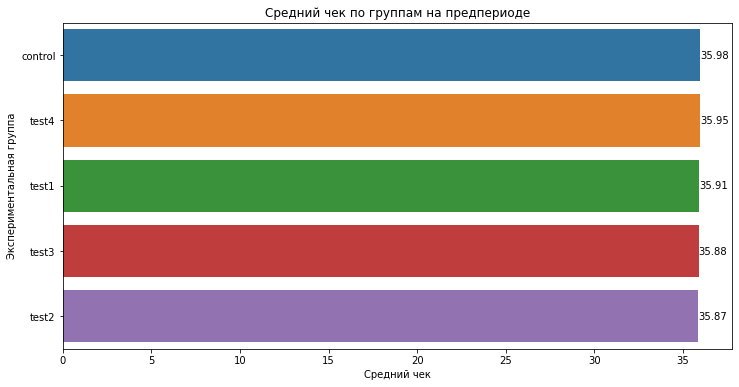

In [46]:
plt.figure(figsize=(12,6))
ax = sns.barplot(data=df_before.groupby('tag', as_index=False) \
                 .agg({'price': 'mean'}) \
                 .rename(columns={'price': 'avg_check'}) \
                 .round(2) \
                 .sort_values('avg_check', ascending=False),
           y='tag',
           x='avg_check')
ax.bar_label(ax.containers[0])
ax.set(title='Средний чек по группам на предпериоде')
ax.set_xlabel('Средний чек')
ax.set_ylabel('Экспериментальная группа');

In [68]:
df_before['log_price'] = np.log(df_before['price'])

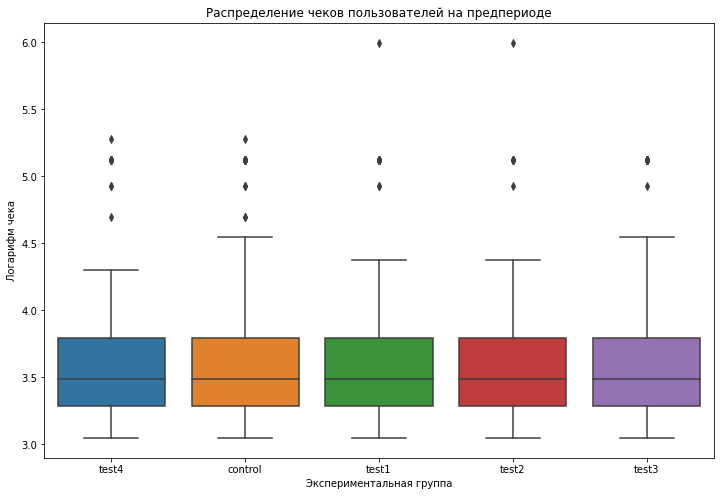

In [160]:
plt.figure(figsize=(12,8))
ax = sns.boxplot(data=df_before, x='tag', y='log_price')
ax.set(title='Распределение чеков пользователей на предпериоде')
ax.set(xlabel='Экспериментальная группа', ylabel='Логарифм чека')
var = ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

Средние значения визуально не отличаются. Можно отметить, что в контрольной группе шире разброс чеков и больше чеков на крупные сумммы. В третьей тестовой группе разброс примерно как в контрольной

Построим графики распределения чеков по каждой из тестовых групп. Отбросим выбросы, чтобы они не искажали картину

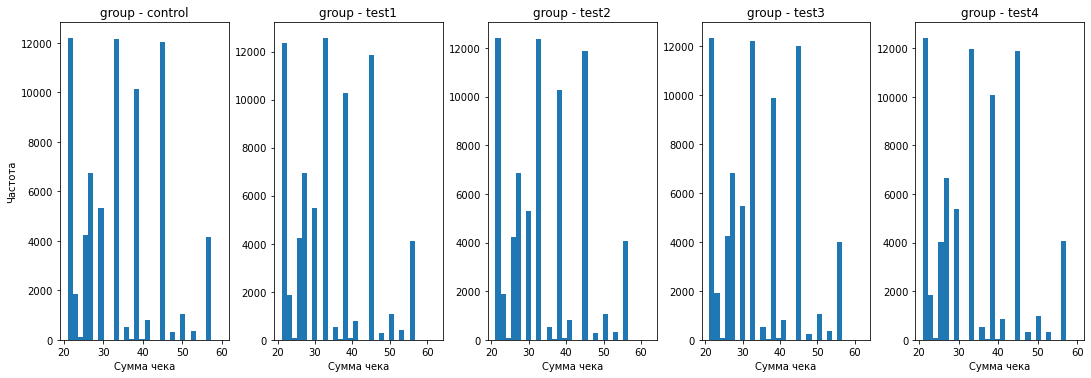

In [132]:
fig, axs = plt.subplots(1,5, figsize=(15,5))
fig.tight_layout()

g1 = axs[0]
g1.hist(df_before.query("tag == 'control'")[df_before['price'] < df_before['price'].quantile(0.99)]['price'], bins=30)
g1.set_title('group - control')
g1.set_xlabel('Сумма чека')
g1.set_ylabel('Частота')

g2 = axs[1]
g2.hist(df_before.query("tag == 'test1'")[df_before['price'] < df_before['price'].quantile(0.99)]['price'], bins=30)
g2.set_title('group - test1')
g2.set_xlabel('Сумма чека')

g3 = axs[2]
g3.hist(df_before.query("tag == 'test2'")[df_before['price'] < df_before['price'].quantile(0.99)]['price'], bins=30)
g3.set_title('group - test2')
g3.set_xlabel('Сумма чека')

g4 = axs[3]
g4.hist(df_before.query("tag == 'test3'")[df_before['price'] < df_before['price'].quantile(0.99)]['price'], bins=30)
g4.set_title('group - test3')
g4.set_xlabel('Сумма чека')

g5 = axs[4]
g5.hist(df_before.query("tag == 'test4'")[df_before['price'] < df_before['price'].quantile(0.99)]['price'], bins=30)
g5.set_title('group - test4')
g5.set_xlabel('Сумма чека')

plt.show();

Распределение визуально отличается от нормального. Попробуем нормализовать распределение чеков с помощью логарифмирования

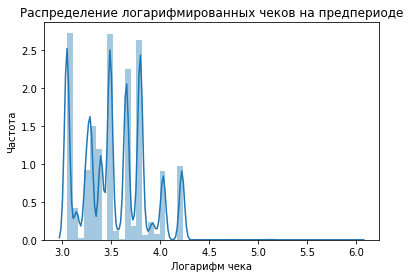

In [161]:
ax = sns.distplot(np.log(df_before.price))
ax.set(title='Распределение логарифмированных чеков на предпериоде')
ax.set_xlabel('Логарифм чека')
ax.set_ylabel('Частота')
plt.show();

In [29]:
df_before['log_price'] = np.log(df_before['price'])

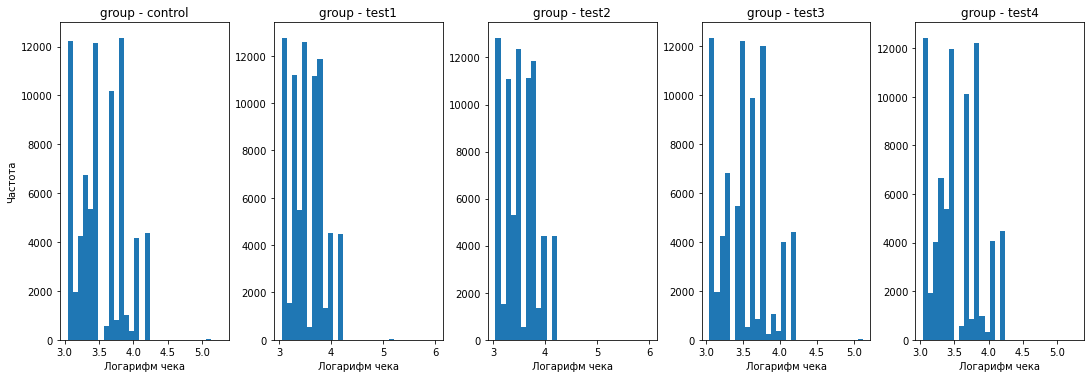

In [138]:
fig, axs = plt.subplots(1,5, figsize=(15,5))
fig.tight_layout()

g1 = axs[0]
g1.hist(df_before.query("tag == 'control'")['log_price'], bins=30)
g1.set_title('group - control')
g1.set_xlabel('Логарифм чека')
g1.set_ylabel('Частота')

g2 = axs[1]
g2.hist(df_before.query("tag == 'test1'")['log_price'], bins=30)
g2.set_title('group - test1')
g2.set_xlabel('Логарифм чека')

g3 = axs[2]
g3.hist(df_before.query("tag == 'test2'")['log_price'], bins=30)
g3.set_title('group - test2')
g3.set_xlabel('Логарифм чека')

g4 = axs[3]
g4.hist(df_before.query("tag == 'test3'")['log_price'], bins=30)
g4.set_title('group - test3')
g4.set_xlabel('Логарифм чека')

g5 = axs[4]
g5.hist(df_before.query("tag == 'test4'")['log_price'], bins=30)
g5.set_title('group - test4')
g5.set_xlabel('Логарифм чека')

plt.show();

Распределения визуально явно отличаются от нормальных. Чтобы удостовериться, используем статистический тест Шапиро-Уилка, который стандартно применяется для проверки отличия распределения от нормального

In [172]:
from scipy import stats

In [185]:
query_name = "tag == {} and price > 0"
for i in df_before.tag.unique():
    print(i, ':', stats.shapiro(df_before.query(query_name.format("'"+i+"'")).price.sample(1000, random_state=17)))

test4 : ShapiroResult(statistic=0.8951545357704163, pvalue=1.5285534660742788e-25)
control : ShapiroResult(statistic=0.8639017343521118, pvalue=1.4301203450635087e-28)
test1 : ShapiroResult(statistic=0.9032914638519287, pvalue=1.2183044560716866e-24)
test2 : ShapiroResult(statistic=0.89411860704422, pvalue=1.184106596273257e-25)
test3 : ShapiroResult(statistic=0.9014635682106018, pvalue=7.556734283307507e-25)


**Распределения для всех групп значимо отличаются от нормального.** 
<br>
<br>
Чтобы применять параметрический тест, необходимо, чтобы в группах соблюдалась гомогенность дисперсий. Чтобы проверить ее наличие, используем тест Левена, который проверяет выборки на принадлежность к генеральным совокупностям с равными дисперсиями

In [428]:
stats.levene(df_before.query("tag == 'control'  and price > 0").price,
            df_before.query("tag == 'test1'  and price > 0").price,
            df_before.query("tag == 'test2'  and price > 0").price,
            df_before.query("tag == 'test3'  and price > 0").price,
            df_before.query("tag == 'test4'  and price > 0").price)

LeveneResult(statistic=1.6332167128309865, pvalue=0.16273365510890075)

**Требование к гомогенности дисперсий соблюдается.** При этом данные не распределены нормально, поэтому используем непараметрический тест Краскела-Уоллиса, который позволяет сравнивать средние значения выборок. Тест Краскела-Уоллиса необходим, так как мы сравниваем более 2 групп. В этом случае если использовать непараметрический тест Манна-Уитни, который сравнивает две группы между собой, попарно, мы завышаем вероятность ошибки первого рода. Тест Краскела-Уоллиса, разработанный специально для множественных сравнений, помогает избавиться от такой проблемы. Этот тест проверяет, есть ли среди групп хотя бы одна, которая статистически значимо отличается от других. В случае если да, надо будет применять пост-хок тест, чтобы определить, в каких именно группах наблюдаются отличия

In [430]:
stats.kruskal(df_before.query("tag == 'control' and price > 0").price,
            df_before.query("tag == 'test1' and price > 0").price,
            df_before.query("tag == 'test2' and price > 0").price,
            df_before.query("tag == 'test3' and price > 0").price,
            df_before.query("tag == 'test4' and price > 0").price)

KruskalResult(statistic=4.626326833626191, pvalue=0.3278300422446007)

Пи-велью выше альфы (0.05), значит не можем отвергнуть гипотезу об отсутствии различий. 
<br>
**Распределение по среднему чеку равномерно**

Посмотрим на **конверсию** в предпериоде

In [48]:
df_before['converted'] = np.where(df_before['time'] > 0, 1, 0)

In [432]:
df_before.nunique()

tag                       5
ts                   625606
user_uid             625988
registration_time    622839
conv_ts                2887
time                 383102
consumption_mode          3
element_uid            5999
price                    46
log_price                46
converted                 2
dtype: int64

In [49]:
df_before_conv = df_before.groupby('user_uid', as_index=False).agg({'tag': 'max', 'converted': 'max'})
df_before_conv.groupby('tag', as_index=False).agg({'converted': 'mean'}).rename(columns={'converted': 'conversion'})

,tag,conversion
0,control,0.367001
1,test1,0.370298
2,test2,0.367373
3,test3,0.366753
4,test4,0.365984


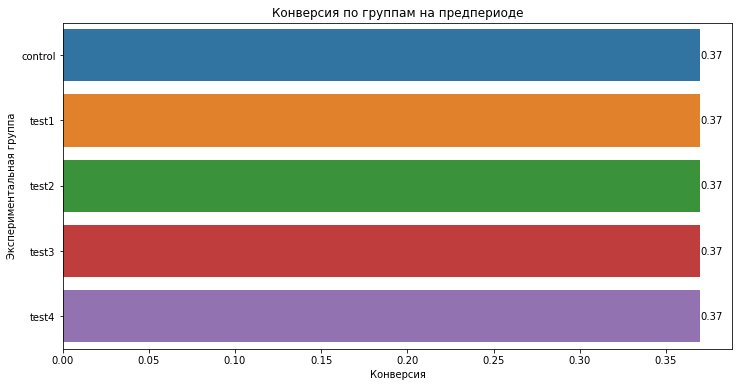

In [59]:
plt.figure(figsize=(12,6))
ax = sns.barplot(data=df_before_conv.groupby('tag', as_index=False) \
                 .agg({'converted': 'mean'}) \
                 .rename(columns={'converted': 'conversion'}) \
                 .round(2) \
                 .sort_values('conversion', ascending=False),
           y='tag',
           x='conversion')
ax.bar_label(ax.containers[0])
ax.set(title='Конверсия по группам на предпериоде')
ax.set_xlabel('Конверсия')
ax.set_ylabel('Экспериментальная группа');

Когда мы сравниваем конверсии, мы имеем дело по сути с качественными переменными. В каждой из пяти групп есть сконвертировавшиеся и не сконвертировавшиеся пользователи. На основании этого можно построить таблицу сопряженности, которая покажет как в каждой группе распределяются сконвертировавшиеся и не сконвертировавшиеся пользователи. Тест сопряженности хи-квадрат проверяет независимость переменных в таблице сопряженности. Этот статичтисечкий критерий используют, когда анализируемые переменные - номинативные. При пи-велью выше уровня значимости мы не сможем отвергнуть гипотезу о том, что распределение в группах не отличаются

In [192]:
from scipy.stats import chi2_contingency, chi2 

In [434]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df_before_conv.tag, df_before_conv.converted))
stat, p

(5.909481751909995, 0.20601098322831232)

**Конверсии статистически не отличаются. Распределение равномерно и валидно**

# Часть 3: Анализ результатов эксперимента

Метрики, на которые стоит обратить внимание:
- конверсия в транзакцию, 
- конверсия в каждый тип транзакции (покупка, аренда, подписка), 
- конверсия в повторную покупку,
- средний чек, 
- ARPU, 
- ARPPU,
- частотность покупок

Для бизнеса важны те метрики, которые отражают возможность зарабатывать на пользовательской базе. Конверсия отражает корректность и удобство пользовательского пути. Если она растет, то нововведения удобнее для пользователя и бОльший процент людей готов тратить деньги в нашем сервисе. Это касается как общей конверсии, так и конверсии в каждый тип продукта 

Конверсия в повторную покупку показывает, насколько нововведения подталкивают пользователя к совершению повторных транзакций. Эта метрика нужна, чтобы отследить, как много пользователей попробовали наш сервис и продолжили им пользоваться (а не отказались). С помощью конверсии в повторную покупку можно косвенно понять, насколько наш сервис удобен и позволяет удерживать пользователей (можно сказать, что это прокси для retention rate), обеспечивая Okko не разовый, а более стабильный доход

Средний чек, ARPU и ARPPU - это денежные метрики, которые позволяют отследить, насколько хорошо мы зарабатываем. 
<br>
Если у нас растет средний чек, значит, нововведение подталкивает пользователей совершать более дорогие покупки и за счет этого увеличивается наш доход. Доход компании складывается из количества пользователей, конверсии и среднего чека. При равном количестве пользователей в группах, необходимо оценить конверсию и средний чек
<br>
Изучая ARPU, мы понимаем, что продукт ценен для пользователей, какой доход мы получаем со всей клиентской базы, учитывая, что у нас могут быть клиенты, не совершившие транзакций, метрика наиболее полно отражает ситуацию в сервисе
<br>
Смотреть на ARPPU необходимо, чтобы отслеживать, тратит ли каждый клиент больше или меньше в нашем приложении. Повлияло ли наше изменение на количество денег, которое платящий пользователь готов оставить в нашем сервисе, принимает ли он нововведение и насколько больше он готов платить

Частотность помогает посмотреть, сколько транзакций совершают пользователи, насколько лояльны они к нашему сервису. Эта метрика тоже своего рода прокси для мониторинга удержания клиентов. 

Посмотрим на **конверсию**

Оставим данные по тем юзерам, которые совершили транзакцию после присвоения тега, а также тех, кто не совершил транзакции (вне зависимости от времени регистрации, так как зарегестрировавшиеся до начала эксперимента могли сконвертироваться в ходе теста)

In [91]:
df_after = df.query("time > ts or time.isnull()")

In [92]:
df_after['converted'] = np.where(df_after['time'] > 0, 1, 0)

In [23]:
df_after_conv = df_after.groupby('user_uid', as_index=False).agg({'tag': 'max', 'converted': 'max'})
df_after_conv.groupby('tag', as_index=False).agg({'converted': 'mean'}).rename(columns={'converted': 'conversion'})

,tag,conversion
0,control,0.272493
1,test1,0.282117
2,test2,0.279162
3,test3,0.279821
4,test4,0.279887


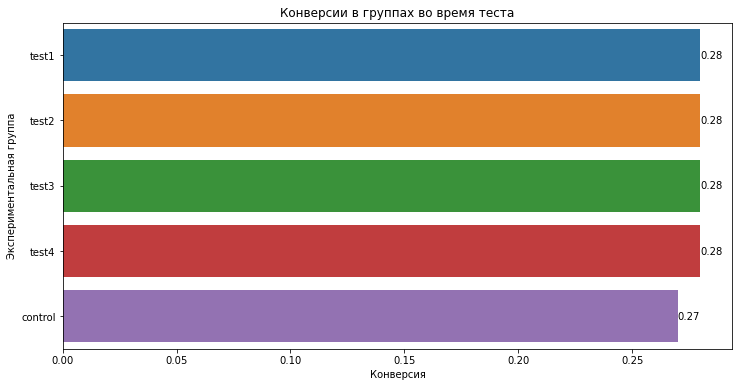

In [58]:
plt.figure(figsize=(12,6))
ax = sns.barplot(data=df_after_conv.groupby('tag', as_index=False) \
            .agg({'converted': 'mean'}) \
            .rename(columns={'converted': 'conversion'}) \
            .round(2) \
            .sort_values('conversion', ascending=False),
           y='tag',
           x='conversion')
ax.bar_label(ax.containers[0])
ax.set(title='Конверсии в группах во время теста')
ax.set_xlabel('Конверсия')
ax.set_ylabel('Экспериментальная группа');

Видим, что конверсия в контрольной группе ниже, чем в тестовых

Как было описано ранее, конверсии можно сравнивать хи-квадратом, чтобы проверить, отличается ли распределение сконвертировавшихся и не сконвертировавшихся в разных группах

In [438]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df_after_conv.tag, df_after_conv.converted))
stat, p

(29.039865897309706, 7.672962636732087e-06)

**Конверсии статистически значимо отличаются.** Посмотрим, в каких группах есть это различие - проведем попарные сравнения. Но так как при попарных сравнениях растет вероятность ошибки первого рода - применим поправку Бонферони (для каждой пары стат значимость различий подтверждается не при p-value ниже альфы 0.05, а при p-value ниже альфы, деленной на кол-во всех попарных сравнений). Так как у нас 5 групп, то совершается 10 попарных сравнений (при этом мы будем смотреть только разницу каждого теста с контролем). Соответственно, пи-велью для каждого попарного сравнения должен быть ниже 0.005

In [198]:
query_name = "tag == 'control' or tag == {}"
for i in df_after_conv.tag.unique():
    stat, p, dof, expected = chi2_contingency(pd.crosstab(df_after_conv.query(query_name.format("'"+i+"'")).tag, 
                                                              df_after_conv.query(query_name.format("'"+i+"'")).converted))
    print(i, ':', 'statistic =', stat, 'p-value =', p)

test4 : statistic = 15.025860440430986 p-value = 0.00010604798801522589
test2 : statistic = 12.22278423613238 p-value = 0.00047209426865192275
test1 : statistic = 25.436913641125088 p-value = 4.5708769945957217e-07
control : statistic = 0.0 p-value = 1.0
test3 : statistic = 14.753179344181333 p-value = 0.00012254072111288805


**В каждой группе конверсия выросла значимо.** В первой группе - на 3.5%, во второй группе - на 2.4%, в третьей группе - на 2.7%, в четвертой группе - на 2.7%

Посмотрим на **конверсию в повторную покупку**

In [53]:
df_after_conv2 = df_after.query("time > 0").groupby("user_uid", as_index=False).agg({'tag': 'max', 'price': 'count'})

In [54]:
df_after_conv2['converted'] = np.where(df_after_conv2['price'] > 1, 1, 0)

In [55]:
df_after_conv2.groupby('tag').agg({'converted': 'mean'}).rename(columns={'converted': 'conversion'})

,conversion
tag,
control,0.369376
test1,0.383863
test2,0.385510
test3,0.384924
test4,0.389199


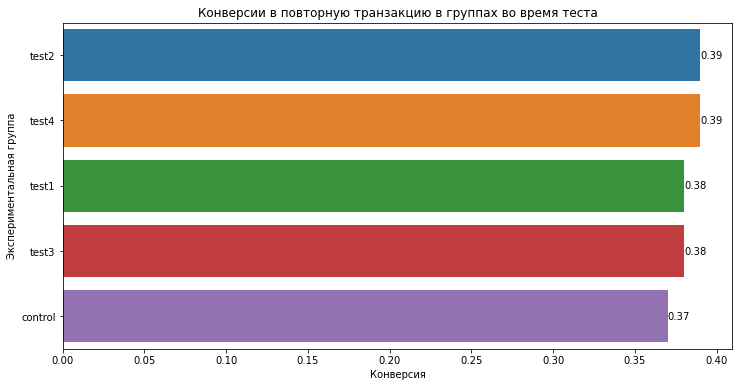

In [57]:
plt.figure(figsize=(12,6))
ax = sns.barplot(data=df_after_conv2.groupby('tag', as_index=False) \
            .agg({'converted': 'mean'}) \
            .rename(columns={'converted': 'conversion'}) \
            .round(2) \
            .sort_values('conversion', ascending=False),
           y='tag',
           x='conversion')
ax.bar_label(ax.containers[0])
ax.set(title='Конверсии в повторную транзакцию в группах во время теста')
ax.set_xlabel('Конверсия')
ax.set_ylabel('Экспериментальная группа');

Видим, что в контрольной группе метрика ниже. Проверим значимость

In [201]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df_after_conv2.tag, df_after_conv2.converted))
stat, p

(29.845909907981287, 5.260980308667034e-06)

**Отличия между группами по конверсии во повторную покупку значимы.** Так же, как и с конверсией в первую транзакцию, сделаем попарные сравнения, помня, что уровень значимости теперь 0.005

In [202]:
query_name = "tag == 'control' or tag == {}"
for i in df_after_conv.tag.unique():
    stat, p, dof, expected = chi2_contingency(pd.crosstab(df_after_conv2.query(query_name.format("'"+i+"'")).tag, 
                                                          df_after_conv2.query(query_name.format("'"+i+"'")).converted))
    print(i, ':', 'statistic =', stat, 'p-value =', p)

test4 : statistic = 25.294573525867193 p-value = 4.920912141076293e-07
test2 : statistic = 16.74520865132184 p-value = 4.275008380617694e-05
test1 : statistic = 13.598667233785346 p-value = 0.0002263461635658186
control : statistic = 0.0 p-value = 1.0
test3 : statistic = 15.573397445611588 p-value = 7.936338405346471e-05


**В каждой группе конверсия в повторную транзакцию стат значимо выросла.** У первой группы - на 3.9%, у второй группы - на 4.4%, у третьей группы - на 4.3%, у четвертой - на 5.4%

Посмотрим на **конверсии в каждый тип транзакций. Начнем с покупки.**

In [62]:
df_after_dto = df_after
df_after_dto['converted'] = np.where(df_after_dto['consumption_mode'] == 'dto', 1, 0)

In [65]:
df_after_dto_group = df_after_dto.groupby('user_uid', as_index=False) \
                                .agg({'tag': 'max', 'converted': 'max'}) \
                                .groupby('tag', as_index=False) \
                                .agg({'converted': 'mean'}) \
                                .rename(columns={'converted': 'conversion_dto'})
df_after_dto_group

,tag,conversion_dto
0,control,0.105396
1,test1,0.116498
2,test2,0.114033
3,test3,0.115765
4,test4,0.118734


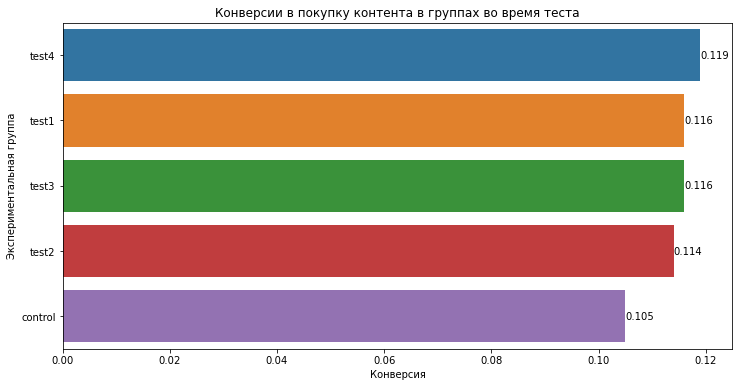

In [69]:
plt.figure(figsize=(12,6))
ax = sns.barplot(data=df_after_dto_group \
            .round(3) \
            .sort_values('conversion_dto', ascending=False),
            y='tag',
            x='conversion_dto')
ax.bar_label(ax.containers[0])
ax.set(title='Конверсии в покупку контента в группах во время теста')
ax.set_xlabel('Конверсия')
ax.set_ylabel('Экспериментальная группа');

Визуально конверсия в покупку в контрольной группе существенно ниже, чем во всех тестовых. Проверим формальным тестом

In [453]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df_after_dto.converted, df_after_dto.tag))
stat, p

(178.22384138762862, 1.7945965042914303e-37)

**Различия между группами по конверсии в покупку есть**

Посмотрим на отличие каждой группы от контроля, помня, что уровень значимости теперь 0.005

In [204]:
query_name = "tag == 'control' or tag == {}"
for i in df_after_conv.tag.unique():
    stat, p, dof, expected = chi2_contingency(pd.crosstab(df_after_dto.query(query_name.format("'"+i+"'")).tag, 
                                                          df_after_dto.query(query_name.format("'"+i+"'")).converted))
    print(i, ':', 'statistic =', stat, 'p-value =', p)

test4 : statistic = 158.21283603429816 p-value = 2.7805803839837253e-36
test2 : statistic = 80.21871976552029 p-value = 3.351767047303828e-19
test1 : statistic = 89.51064755598779 p-value = 3.049925766087823e-21
control : statistic = 0.0 p-value = 1.0
test3 : statistic = 96.29386087626415 p-value = 9.903665349987945e-23


**Конверсия в покупку стат значимо увеличилось в каждой группе.** У первой группы - на 10.5%, у второй группы - на 8.2%, у третьей группы - на 9.8%, у четвертой группы - на 12.6%

Посмотрим на **конверсию в аренду**

In [70]:
df_after_rent = df_after
df_after_rent['converted'] = np.where(df_after_dto['consumption_mode'] == 'rent', 1, 0)

In [71]:
df_after_rent_group = df_after_rent.groupby('user_uid', as_index=False) \
                                    .agg({'tag': 'max', 'converted': 'max'}) \
                                    .groupby('tag', as_index=False) \
                                    .agg({'converted': 'mean'}) \
                                    .rename(columns={'converted': 'conversion_rent'})
df_after_rent_group

,tag,conversion_rent
0,control,0.104146
1,test1,0.106275
2,test2,0.107267
3,test3,0.105956
4,test4,0.104993


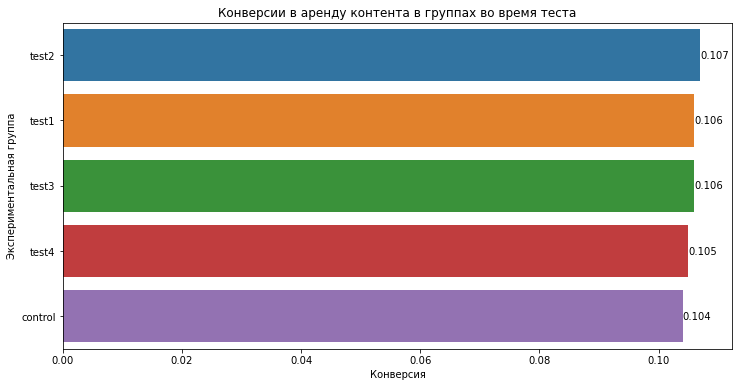

In [72]:
plt.figure(figsize=(12,6))
ax = sns.barplot(data=df_after_rent_group \
            .round(3) \
            .sort_values('conversion_rent', ascending=False),
            y='tag',
            x='conversion_rent')
ax.bar_label(ax.containers[0])
ax.set(title='Конверсии в аренду контента в группах во время теста')
ax.set_xlabel('Конверсия')
ax.set_ylabel('Экспериментальная группа');

Заметно увеличение конверсии во всех тестовых группах, однако не такое явное, как в случае покупки контента. Проверим статистическую значимость

In [460]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df_after_rent.converted, df_after_rent.tag))
stat, p

(9.272181138493414, 0.054644871818728374)

Пи-велью выше уровня значимости. **Не можем утверждать, что есть различия между конверсиями в аренду хотя бы в одной группе**

Посмотрим на **конверсию в приобретение подписки**

In [74]:
df_after_sub = df_after
df_after_sub['converted'] = np.where(df_after_sub['consumption_mode'] == 'subscription', 1, 0)

In [75]:
df_after_sub_group = df_after_sub.groupby('user_uid', as_index=False) \
                                .agg({'tag': 'max', 'converted': 'max'}) \
                                .groupby('tag', as_index=False) \
                                .agg({'converted': 'mean'}) \
                                .rename(columns={'converted': 'conversion_sub'})
df_after_sub_group

,tag,conversion_sub
0,control,0.133072
1,test1,0.135357
2,test2,0.133516
3,test3,0.135412
4,test4,0.132765


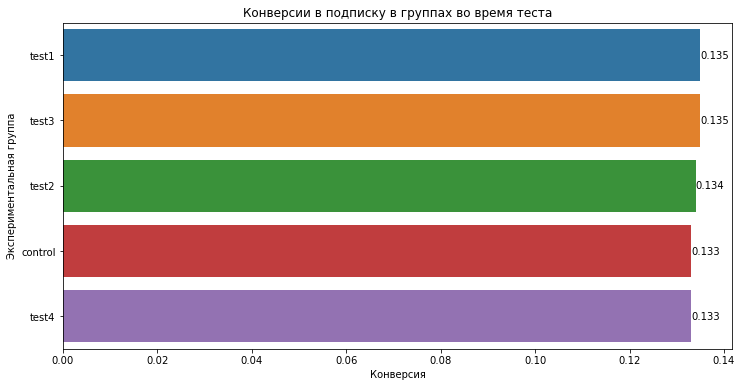

In [76]:
plt.figure(figsize=(12,6))
ax = sns.barplot(data=df_after_sub_group \
            .round(3) \
            .sort_values('conversion_sub', ascending=False),
            y='tag',
            x='conversion_sub')
ax.bar_label(ax.containers[0])
ax.set(title='Конверсии в подписку в группах во время теста')
ax.set_xlabel('Конверсия')
ax.set_ylabel('Экспериментальная группа');

Визуально конверсия в подписку практически не изменилась, а для четвертой группы даже немного упала. Проведем формальный тест

In [463]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df_after_sub.converted, df_after_sub.tag))
stat, p

(4.9566318656252, 0.29177635330640694)

Конверсия в подписку значимо не изменилась

**Наибольший прирост конверсии (повторной, в покупку) наблюдается у 4 тестовой группы. Наибольший прирост первой конверсии в транзакцию - у 1 тестовой группы**

Посмотрим на **средний чек**

In [464]:
df_after.groupby('tag', as_index=False).agg({'price': 'mean'}).rename(columns={'price': 'avg_check'})

,tag,avg_check
0,control,38.618944
1,test1,38.280936
2,test2,38.399636
3,test3,38.322629
4,test4,38.174531


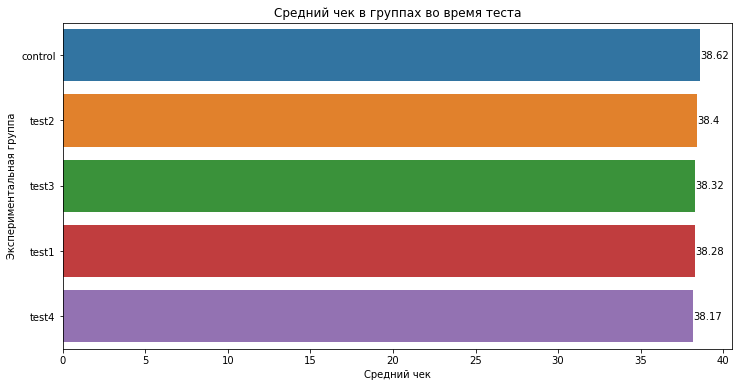

In [78]:
plt.figure(figsize=(12,6))
ax = sns.barplot(data=df_after.groupby('tag', as_index=False) \
                 .agg({'price': 'mean'}) \
                 .rename(columns={'price': 'avg_check'}) \
                 .round(2) \
                 .sort_values('avg_check', ascending=False),
                 y='tag',
                 x='avg_check')
ax.bar_label(ax.containers[0])
ax.set(title='Средний чек в группах во время теста')
ax.set_xlabel('Средний чек')
ax.set_ylabel('Экспериментальная группа');

Можно увидеть, что средний чек упал во всех группах по сравнению с контролем, но не значительно

Посмотрим на распределение чеков в ходе эксперимента. Отбросим верхний перцентиль с экстремально высокими значениями

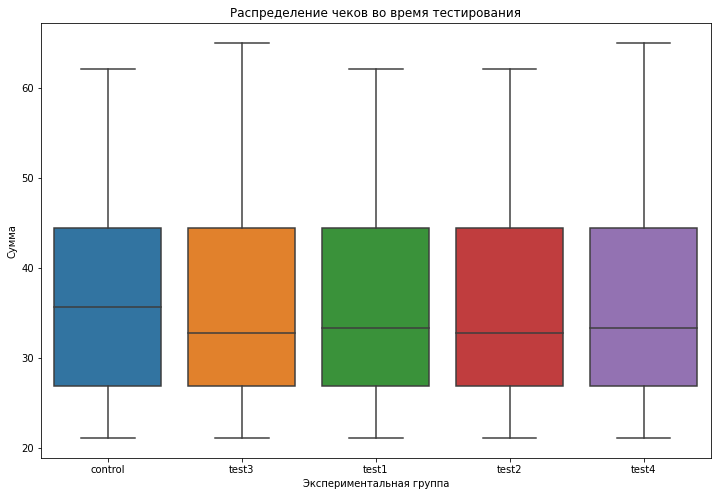

In [225]:
plt.figure(figsize=(12,8))
ax = sns.boxplot(data=df_after[df_after['price'] < df_after['price'].quantile(0.99)], x='tag', y='price')
ax.set(title='Распределение чеков во время тестирования')
ax.set(xlabel='Экспериментальная группа', ylabel='Сумма')
var = ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

По графику видно, что средний чек в контрольной группе выше, чем во всех тестовых

Нарисуем гистограмму распределения без выбросов (отбросим последний перцентиль)

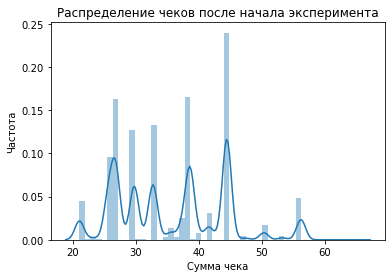

In [144]:
ax = sns.distplot(df_after[df_after['price'] < df_after['price'].quantile(0.99)].price)
ax.set(title='Распределение чеков после начала эксперимента')
ax.set_xlabel('Сумма чека')
ax.set_ylabel('Частота')
plt.show();

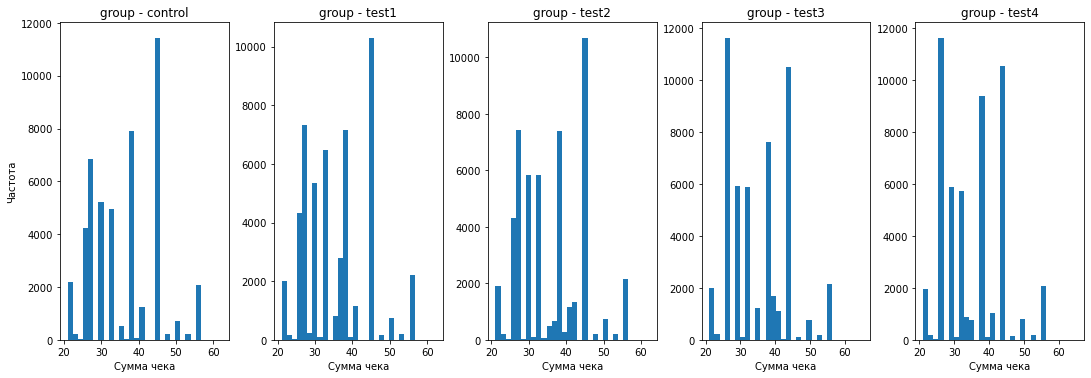

In [146]:
fig, axs = plt.subplots(1,5, figsize=(15,5))
fig.tight_layout()

g1 = axs[0]
g1.hist(df_after.query("tag == 'control'")[df_after['price'] < df_after['price'].quantile(0.99)]['price'], bins=30)
g1.set_title('group - control')
g1.set_xlabel('Сумма чека')
g1.set_ylabel('Частота')

g2 = axs[1]
g2.hist(df_after.query("tag == 'test1'")[df_after['price'] < df_after['price'].quantile(0.99)]['price'], bins=30)
g2.set_title('group - test1')
g2.set_xlabel('Сумма чека')

g3 = axs[2]
g3.hist(df_after.query("tag == 'test2'")[df_after['price'] < df_after['price'].quantile(0.99)]['price'], bins=30)
g3.set_title('group - test2')
g3.set_xlabel('Сумма чека')

g4 = axs[3]
g4.hist(df_after.query("tag == 'test3'")[df_after['price'] < df_after['price'].quantile(0.99)]['price'], bins=30)
g4.set_title('group - test3')
g4.set_xlabel('Сумма чека')

g5 = axs[4]
g5.hist(df_after.query("tag == 'test4'")[df_after['price'] < df_after['price'].quantile(0.99)]['price'], bins=30)
g5.set_title('group - test4')
g5.set_xlabel('Сумма чека')

plt.show();

Распределение визуально отличается от нормального, попробуем логарифмировать

In [93]:
df_after['log_price'] = np.log(df_after['price'])

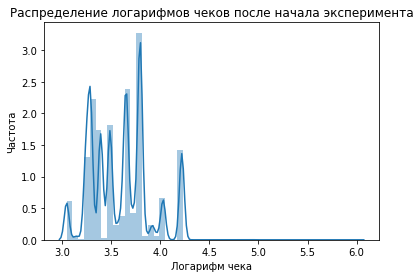

In [150]:
ax = sns.distplot(df_after.log_price)
ax.set(title='Распределение логарифмов чеков после начала эксперимента')
ax.set_xlabel('Логарифм чека')
ax.set_ylabel('Частота')
plt.show();

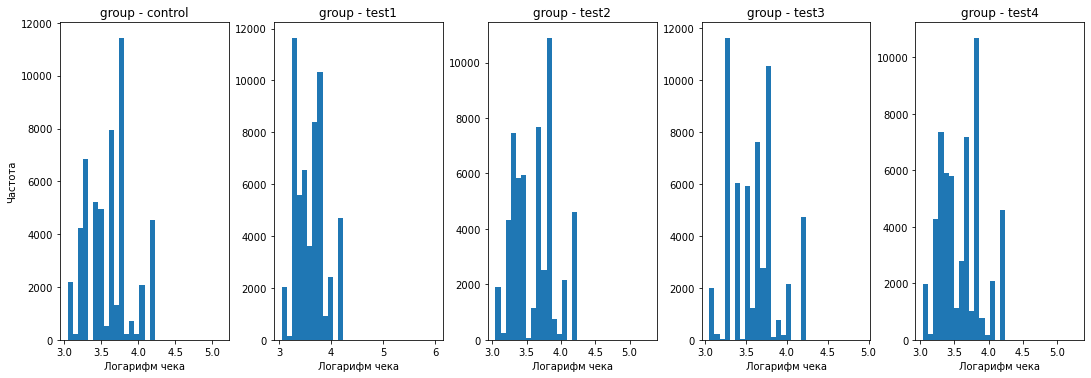

In [151]:
fig, axs = plt.subplots(1,5, figsize=(15,5))
fig.tight_layout()

g1 = axs[0]
g1.hist(df_after.query("tag == 'control'")['log_price'], bins=30)
g1.set_title('group - control')
g1.set_xlabel('Логарифм чека')
g1.set_ylabel('Частота')

g2 = axs[1]
g2.hist(df_after.query("tag == 'test1'")['log_price'], bins=30)
g2.set_title('group - test1')
g2.set_xlabel('Логарифм чека')

g3 = axs[2]
g3.hist(df_after.query("tag == 'test2'")['log_price'], bins=30)
g3.set_title('group - test2')
g3.set_xlabel('Логарифм чека')

g4 = axs[3]
g4.hist(df_after.query("tag == 'test3'")['log_price'], bins=30)
g4.set_title('group - test3')
g4.set_xlabel('Логарифм чека')

g5 = axs[4]
g5.hist(df_after.query("tag == 'test4'")['log_price'], bins=30)
g5.set_title('group - test4')
g5.set_xlabel('Логарифм чека')

plt.show();

Визуально даже логарифмирование не помогает. Проведем статистический тест Шапиро-Уилка для того, чтобы убедиться, что распределение отличается от нормального

In [208]:
query_name = "tag == {} and time > 0"
for i in df_after.tag.unique():
    print(i, ':', stats.shapiro(df_after.query(query_name.format("'"+i+"'")).log_price.sample(1000, random_state=17)))

test4 : ShapiroResult(statistic=0.9445818662643433, pvalue=6.773861135342819e-19)
control : ShapiroResult(statistic=0.9452977180480957, pvalue=9.020404579890767e-19)
test1 : ShapiroResult(statistic=0.9449132084846497, pvalue=7.731624098308648e-19)
test3 : ShapiroResult(statistic=0.9461568593978882, pvalue=1.2767010596994308e-18)
test2 : ShapiroResult(statistic=0.941478431224823, pvalue=2.0168315110328507e-19)


Данные не распределены нормально

Проведем тест Левена, чтобы проверить гомогенность дисперсий в группах

In [475]:
stats.levene(df_after.query("time > 0 and tag == 'control'").log_price,
            df_after.query("time > 0 and tag == 'test1'").log_price,
            df_after.query("time > 0 and tag == 'test2'").log_price,
            df_after.query("time > 0 and tag == 'test3'").log_price,
            df_after.query("time > 0 and tag == 'test4'").log_price)

LeveneResult(statistic=22.1314235135009, pvalue=2.7262735367326688e-18)

Не соблюдаются требования ни гомогенности дисперсий, ни нормальности распределения. Используем непараметрический критерий Краскела-Уоллиса. Именно он позволяет выявить, есть ли хоть в одной группе статистически значимые отличия в среднем чеке от остальных, учитывая, что условия для параметрического теста (нормальность распределения и гомогенность дисперсий) не соблюдаются

In [476]:
stats.kruskal(df_after.query("time > 0 and tag == 'control'").price,
            df_after.query("time > 0 and tag == 'test1'").price,
            df_after.query("time > 0 and tag == 'test2'").price,
            df_after.query("time > 0 and tag == 'test3'").price,
            df_after.query("time > 0 and tag == 'test4'").price)

KruskalResult(statistic=56.504587927678244, pvalue=1.5716091893450485e-11)

Различия между группами есть. Однако сейчас все, что мы знаем - как минимум одна группа отличается от остальных. Чтобы отследить, какие именно группы отличаются значимо от контроля, необходимо провести пост-хок анализ, в ходе которого будут попарно сравниваться группы, при этом пи-велью скорректирован на множественные сравнения, чтобы не допустить ошибку первого рода. Проведем пост-хок тест Данна, потому что именно его обычно используют для попарного сравнения групп после непараметрического теста

In [249]:
import scikit_posthocs as sp 

In [477]:
sp.posthoc_dunn(df_after.query("time > 0"), 'price', 'tag', p_adjust='holm')

,control,test1,test2,test3,test4
control,1.000000e+00,7.663195e-08,0.019353,0.001303,9.862214e-11
test1,7.663195e-08,1.000000e+00,0.014681,0.121904,5.623712e-01
test2,1.935265e-02,1.468087e-02,1.000000,0.562371,4.200755e-04
test3,1.302757e-03,1.219043e-01,0.562371,1.000000,1.084869e-02
test4,9.862214e-11,5.623712e-01,0.000420,0.010849,1.000000e+00


**Средний чек в каждой группе статистически значимо снизился.** У первой группы - на 0.9%, у второй группы - на 0.6%, у третьей группы - на 0.8%, у четвертой группы - на 1.1%

Посчитаем **ARPU** и посмотрим, отличаются ли значения статистически значимо

In [80]:
df_arpu = df_after
df_arpu['price'] = df_arpu['price'].fillna(0)

In [81]:
df_arpu = df_arpu.groupby('user_uid', as_index=False).agg({'tag': 'max', 'price': 'sum'})

In [481]:
df_arpu.groupby('tag', as_index=False).agg({'price': 'mean'}).rename(columns={'price': 'ARPU'})

,tag,ARPU
0,control,18.561048
1,test1,19.448464
2,test2,19.348823
3,test3,19.412692
4,test4,19.313863


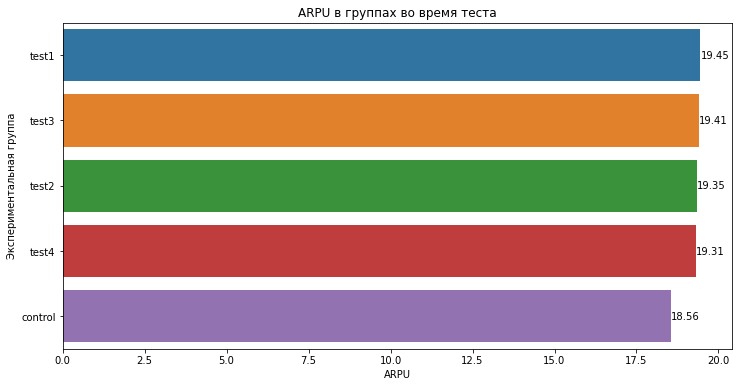

In [82]:
plt.figure(figsize=(12,6))
ax = sns.barplot(data=df_arpu.groupby('tag', as_index=False) \
                 .agg({'price': 'mean'}) \
                 .rename(columns={'price': 'ARPU'}) \
                 .round(2) \
                 .sort_values('ARPU', ascending=False),
                 y='tag',
                 x='ARPU')
ax.bar_label(ax.containers[0])
ax.set(title='ARPU в группах во время теста')
ax.set_xlabel('ARPU')
ax.set_ylabel('Экспериментальная группа');

Можно заметить ощутимый рост ARPU во всех тестовых группах

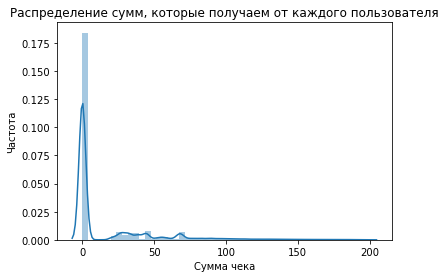

In [152]:
ax = sns.distplot(df_arpu[df_arpu['price'] < df_arpu['price'].quantile(0.99)].price)
ax.set(title='Распределение сумм, которые получаем от каждого пользователя')
ax.set_xlabel('Сумма чека')
ax.set_ylabel('Частота')
plt.show();

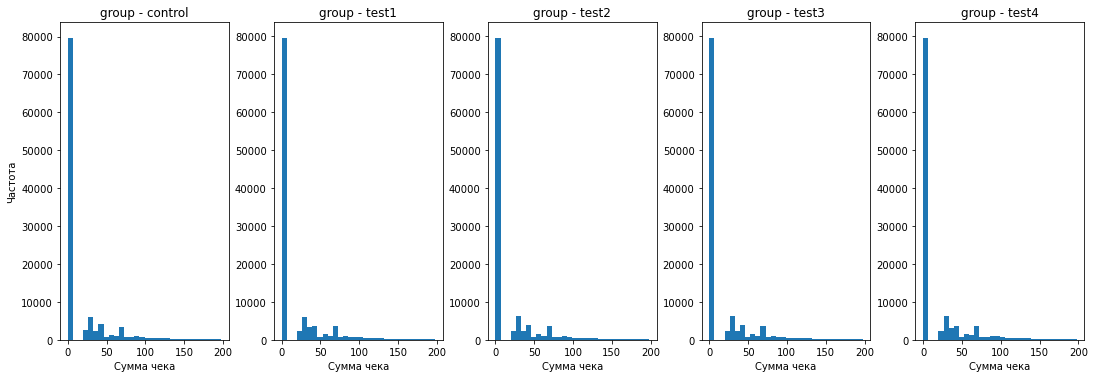

In [153]:
fig, axs = plt.subplots(1,5, figsize=(15,5))
fig.tight_layout()

g1 = axs[0]
g1.hist(df_arpu.query("tag == 'control'")[df_arpu['price'] < df_arpu['price'].quantile(0.99)]['price'], bins=30)
g1.set_title('group - control')
g1.set_xlabel('Сумма чека')
g1.set_ylabel('Частота')

g2 = axs[1]
g2.hist(df_arpu.query("tag == 'test1'")[df_arpu['price'] < df_arpu['price'].quantile(0.99)]['price'], bins=30)
g2.set_title('group - test1')
g2.set_xlabel('Сумма чека')

g3 = axs[2]
g3.hist(df_arpu.query("tag == 'test2'")[df_arpu['price'] < df_arpu['price'].quantile(0.99)]['price'], bins=30)
g3.set_title('group - test2')
g3.set_xlabel('Сумма чека')

g4 = axs[3]
g4.hist(df_arpu.query("tag == 'test3'")[df_arpu['price'] < df_arpu['price'].quantile(0.99)]['price'], bins=30)
g4.set_title('group - test3')
g4.set_xlabel('Сумма чека')

g5 = axs[4]
g5.hist(df_arpu.query("tag == 'test4'")[df_arpu['price'] < df_arpu['price'].quantile(0.99)]['price'], bins=30)
g5.set_title('group - test4')
g5.set_xlabel('Сумма чека')

plt.show();

Распределения явно отличаются от нормального, логарифмирование бессмысленно, так как логарифм нуля не определен. Проверим статистическую значимость различий непараметрическим тестом. Так как ситуация аналогична кейсу со средним чеком, нам так же подходит тест Краскела-Уоллиса

In [483]:
stats.kruskal(df_arpu.query("tag == 'control'").price,
             df_arpu.query("tag == 'test1'").price,
             df_arpu.query("tag == 'test2'").price,
             df_arpu.query("tag == 'test3'").price,
             df_arpu.query("tag == 'test4'").price)

KruskalResult(statistic=33.596195657523204, pvalue=9.016799154999556e-07)

**По крайней мере одна группа отличается от других**. Посмотрим, между какими именно, используя пост-хок тест Данна (так как все аналогично кейсу со средним чеком)

In [484]:
sp.posthoc_dunn(df_arpu, 'price', 'tag', p_adjust='holm')

,control,test1,test2,test3,test4
control,1.000000,0.000001,0.000595,0.000142,0.000174
test1,0.000001,1.000000,1.000000,1.000000,1.000000
test2,0.000595,1.000000,1.000000,1.000000,1.000000
test3,0.000142,1.000000,1.000000,1.000000,1.000000
test4,0.000174,1.000000,1.000000,1.000000,1.000000


**В каждой из тестовых групп ARPU выросла статистически значимо.** У первой группы - на 4.8%, у второй группы - на 4.2%, у третьей группы - на 4.6%, у четвертой группы - на 4.1%

Посмотрим на **ARPPU**

In [84]:
df_arppu = df_after.query("time > 0")

In [85]:
df_arppu = df_arppu.groupby('user_uid').agg({'tag': 'max', 'price': 'sum'})

Построим график распределения дохода с платящего пользователя по группам, убрав последний перцентиль с экстремально большими значениями

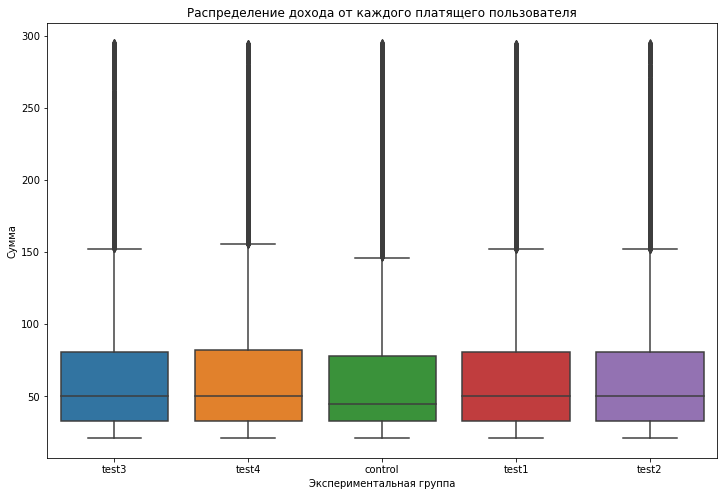

In [217]:
plt.figure(figsize=(12,8))
ax = sns.boxplot(data=df_arppu[df_arppu['price'] < df_arppu['price'].quantile(0.99)], x='tag', y='price')
ax.set(title='Распределение дохода от каждого платящего пользователя')
ax.set(xlabel='Экспериментальная группа', ylabel='Сумма')
var = ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

Визуально можно сделать вывод о том, что среднее значение в контрольной группе ниже, чем в тестовых. При этом все еще достаточно много выбросов. Посмотрим на конкретные значения ARPPU в каждой группе

In [487]:
df_arppu.groupby('tag', as_index=False).agg({'price': 'mean'}).rename(columns={'price': 'ARPPU'})

,tag,ARPPU
0,control,68.115792
1,test1,68.937489
2,test2,69.310454
3,test3,69.375487
4,test4,69.005958


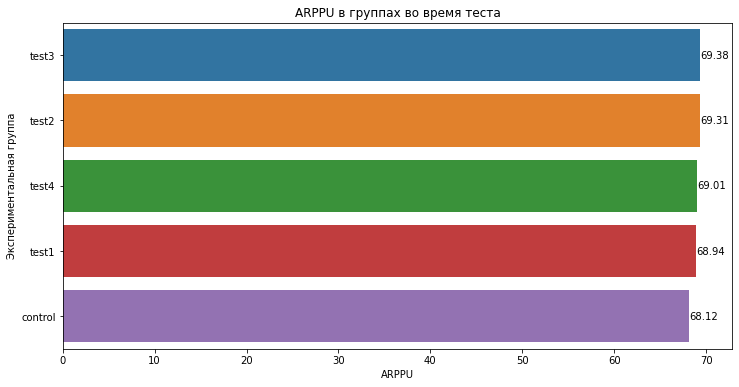

In [86]:
plt.figure(figsize=(12,6))
ax = sns.barplot(data=df_arppu.groupby('tag', as_index=False) \
                 .agg({'price': 'mean'}) \
                 .rename(columns={'price': 'ARPPU'}) \
                 .round(2) \
                 .sort_values('ARPPU', ascending=False),
                 y='tag',
                 x='ARPPU')
ax.bar_label(ax.containers[0])
ax.set(title='ARPPU в группах во время теста')
ax.set_xlabel('ARPPU')
ax.set_ylabel('Экспериментальная группа');

Судя по графику, ARPPU вырос, но не слишком сильно

Визуализируем распределения, чтобы проверить нормальность

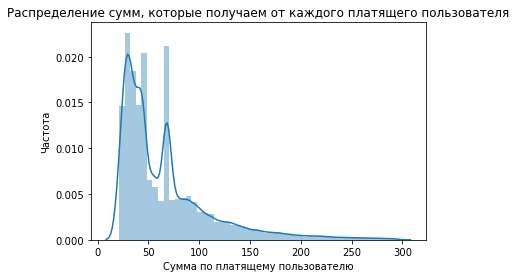

In [218]:
ax = sns.distplot(df_arppu[df_arppu['price'] < df_arppu['price'].quantile(0.99)].price)
ax.set(title='Распределение сумм, которые получаем от каждого платящего пользователя')
ax.set_xlabel('Сумма по платящему пользователю')
ax.set_ylabel('Частота')
plt.show();

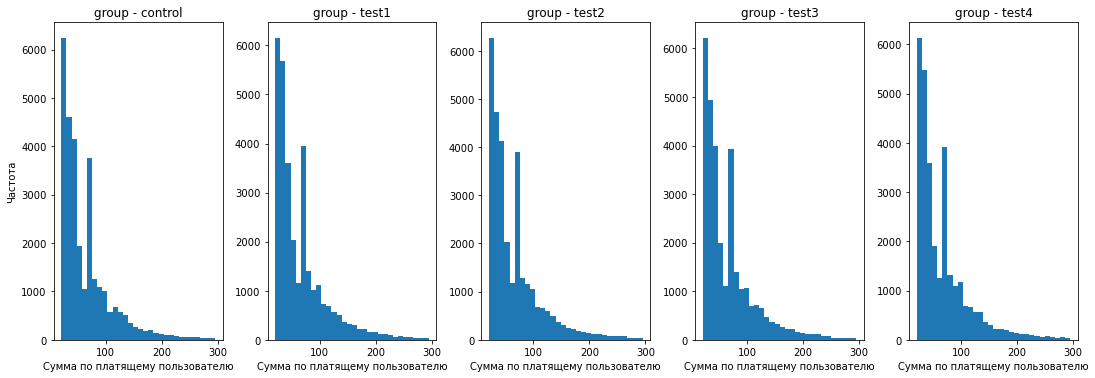

In [219]:
fig, axs = plt.subplots(1,5, figsize=(15,5))
fig.tight_layout()

g1 = axs[0]
g1.hist(df_arppu.query("tag == 'control'")[df_arppu['price'] < df_arppu['price'].quantile(0.99)]['price'], bins=30)
g1.set_title('group - control')
g1.set_xlabel('Сумма по платящему пользователю')
g1.set_ylabel('Частота')

g2 = axs[1]
g2.hist(df_arppu.query("tag == 'test1'")[df_arppu['price'] < df_arppu['price'].quantile(0.99)]['price'], bins=30)
g2.set_title('group - test1')
g2.set_xlabel('Сумма по платящему пользователю')

g3 = axs[2]
g3.hist(df_arppu.query("tag == 'test2'")[df_arppu['price'] < df_arppu['price'].quantile(0.99)]['price'], bins=30)
g3.set_title('group - test2')
g3.set_xlabel('Сумма по платящему пользователю')

g4 = axs[3]
g4.hist(df_arppu.query("tag == 'test3'")[df_arppu['price'] < df_arppu['price'].quantile(0.99)]['price'], bins=30)
g4.set_title('group - test3')
g4.set_xlabel('Сумма по платящему пользователю')

g5 = axs[4]
g5.hist(df_arppu.query("tag == 'test4'")[df_arppu['price'] < df_arppu['price'].quantile(0.99)]['price'], bins=30)
g5.set_title('group - test4')
g5.set_xlabel('Сумма по платящему пользователю')

plt.show();

Распределения отличаются от нормальных

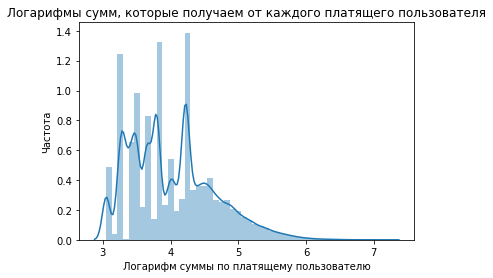

In [221]:
ax = sns.distplot(np.log(df_arppu.price))
ax.set(title='Логарифмы сумм, которые получаем от каждого платящего пользователя')
ax.set_xlabel('Логарифм суммы по платящему пользователю')
ax.set_ylabel('Частота')
plt.show();

Данные распределены не нормально, поэтому используем непараметрику - тест Краскела-Уоллиса для множественного сравнения, как и в случае со средним чеком и ARPU

In [489]:
stats.kruskal(df_arppu.query("tag == 'control'").price,
             df_arppu.query("tag == 'test1'").price,
             df_arppu.query("tag == 'test2'").price,
             df_arppu.query("tag == 'test3'").price,
             df_arppu.query("tag == 'test4'").price)

KruskalResult(statistic=11.29006462451837, pvalue=0.02349041631338823)

Видим, что **как минимум одна группа статистически значимо отличается**. По аналогии со средним чеком и ARPU выберем пост-хок тест Данна, чтобы отследить, какие именно группы значимо отличаются от контрольной

In [490]:
sp.posthoc_dunn(df_arppu, 'price', 'tag', p_adjust='holm')

,control,test1,test2,test3,test4
control,1.000000,0.453437,0.057906,0.028896,0.125168
test1,0.453437,1.000000,1.000000,1.000000,1.000000
test2,0.057906,1.000000,1.000000,1.000000,1.000000
test3,0.028896,1.000000,1.000000,1.000000,1.000000
test4,0.125168,1.000000,1.000000,1.000000,1.000000


**Значимо ARPPU вырос только для третьей тестовой группы - на 1.8%**

Посмотрим на **частотность**

In [94]:
df_freq = df_after.groupby('user_uid', as_index=False) \
            .agg({'tag': 'max', 'price': 'count'}) \
            .rename(columns={'price': 'frequency'})

In [95]:
df_freq.groupby('tag', as_index=False).agg({'frequency': 'mean'})

,tag,frequency
0,control,0.480620
1,test1,0.508046
2,test2,0.503880
3,test3,0.506559
4,test4,0.505936


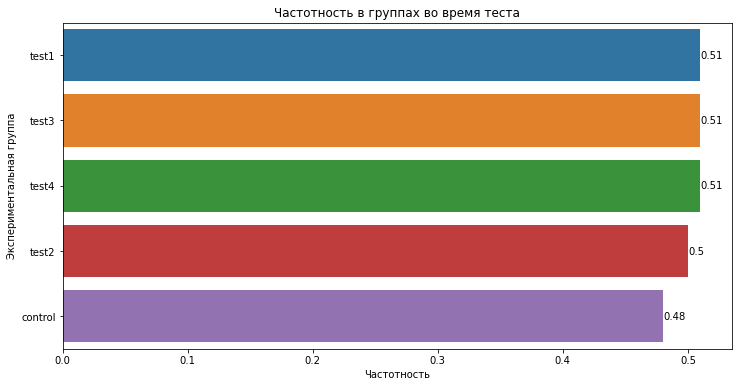

In [98]:
plt.figure(figsize=(12,6))
ax = sns.barplot(data=df_freq.groupby('tag', as_index=False) \
                 .agg({'frequency': 'mean'}) \
                 .round(2) \
                 .sort_values('frequency', ascending=False),
                 y='tag',
                 x='frequency')
ax.bar_label(ax.containers[0])
ax.set(title='Частотность в группах во время теста')
ax.set_xlabel('Частотность')
ax.set_ylabel('Экспериментальная группа');

Визуально частотность значительно увеличилась во всех тестовых группах

Посмотрим, как распределяются частоты внутри групп

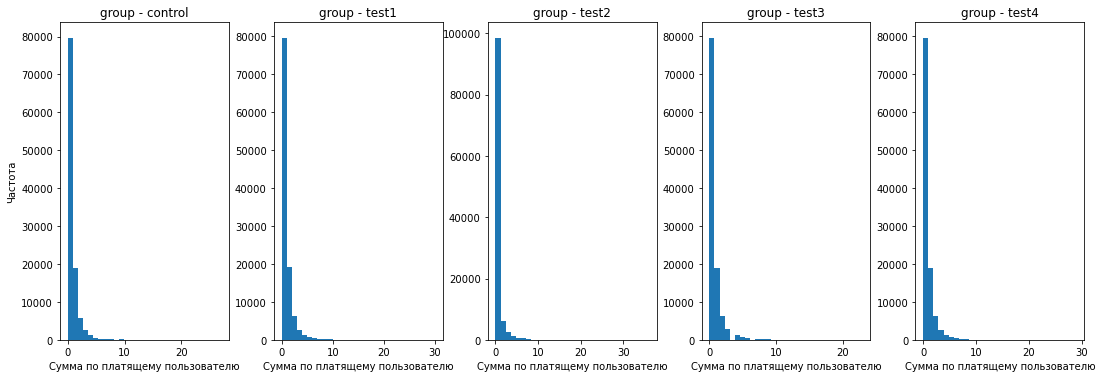

In [247]:
fig, axs = plt.subplots(1,5, figsize=(15,5))
fig.tight_layout()

g1 = axs[0]
g1.hist(df_freq.query("tag == 'control'")['frequency'], bins=30)
g1.set_title('group - control')
g1.set_xlabel('Сумма по платящему пользователю')
g1.set_ylabel('Частота')

g2 = axs[1]
g2.hist(df_freq.query("tag == 'test1'")['frequency'], bins=30)
g2.set_title('group - test1')
g2.set_xlabel('Сумма по платящему пользователю')

g3 = axs[2]
g3.hist(df_freq.query("tag == 'test2'")['frequency'], bins=30)
g3.set_title('group - test2')
g3.set_xlabel('Сумма по платящему пользователю')

g4 = axs[3]
g4.hist(df_freq.query("tag == 'test3'")['frequency'], bins=30)
g4.set_title('group - test3')
g4.set_xlabel('Сумма по платящему пользователю')

g5 = axs[4]
g5.hist(df_freq.query("tag == 'test4'")['frequency'], bins=30)
g5.set_title('group - test4')
g5.set_xlabel('Сумма по платящему пользователю')

plt.show();

Во всех группах, кроме второй, видим схожий паттерн - примерно равномерное снижение количества покупок на пользователя с максимумом около 30 штук. Во второй же группе количество покупок ниже нуля встречается редко, но максимальное значение приближается к 40. Также видим, что распределение отличается от нормального

Применим непараметрический тест Краскела-Уоллиса, так как распределение отличается от нормального и логарифмировать его не имеет смысла (логарифм нуля не определен).

In [248]:
stats.kruskal(df_freq.query("tag == 'control'").frequency,
             df_freq.query("tag == 'test1'").frequency,
             df_freq.query("tag == 'test2'").frequency,
             df_freq.query("tag == 'test3'").frequency,
             df_freq.query("tag == 'test4'").frequency)

KruskalResult(statistic=37.52981475331988, pvalue=1.4008739401204883e-07)

Видим, что хотя бы одна группа значимо отличается от других. Проведем пост-хок тест, чтобы понять, в каких именно группах различия значимы

In [250]:
sp.posthoc_dunn(df_freq, 'frequency', 'tag', p_adjust='holm')

,control,test1,test2,test3,test4
control,1.000000e+00,2.525997e-07,0.000274,0.000059,0.000034
test1,2.525997e-07,1.000000e+00,0.867556,1.000000,1.000000
test2,2.743159e-04,8.675558e-01,1.000000,1.000000,1.000000
test3,5.863999e-05,1.000000e+00,1.000000,1.000000,1.000000
test4,3.397837e-05,1.000000e+00,1.000000,1.000000,1.000000


**Частотность статистически значимо выросла во всех группах.** В первой - на 5.7%, во второй - на 4.8%, в третьей - на 5.4%, в четвертой - на 5.3%

Посмотрим на общую выручку компании по результатам эксперимента

In [101]:
df_rev = df_after.groupby('tag', as_index=False).agg({'price': 'sum'}).rename(columns={'price': 'total_revenue'})
df_rev['total_revenue'] = df_rev['total_revenue'] / 1000000
df_rev

,tag,total_revenue
0,control,2.034755
1,test1,2.157399
2,test2,2.139129
3,test3,2.147102
4,test4,2.137736


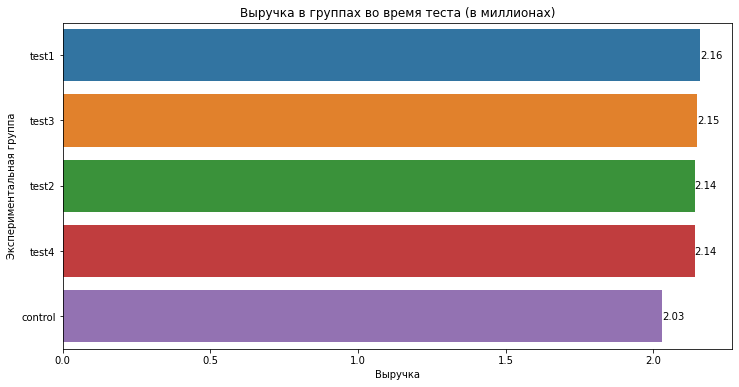

In [104]:
plt.figure(figsize=(12,6))
ax = sns.barplot(data=df_rev \
                 .round(2) \
                 .sort_values('total_revenue', ascending=False),
                 y='tag',
                 x='total_revenue')
ax.bar_label(ax.containers[0])
ax.set(title='Выручка в группах во время теста (в миллионах)')
ax.set_xlabel('Выручка')
ax.set_ylabel('Экспериментальная группа');

Видим, что **в каждой тестовой группе выручка выросла.** В первой - на 6%, во второй - на 5%, в третьей - на 5.5%, в четвертой - на 5%

# Часть 4: Заключение

Выводы: 
<br>
<br>
Конверсия выросла во всех группах
<br>
<br>
Конверсия в повторную покупку выросла во всех группах
<br>
<br>
Конверсия в покупку контента выросла выросла во всех группах. Конверсия в другие типы транзакций - не изменилась (для всех групп)
<br>
<br>
Средний чек снизился в каждой группе
<br>
<br>
ARPU выросла в каждой группе
<br>
<br>
ARPPU выросла только в третьей группе.
<br>
<br>
Для наглядного представления динамики метрик построим таблицу:

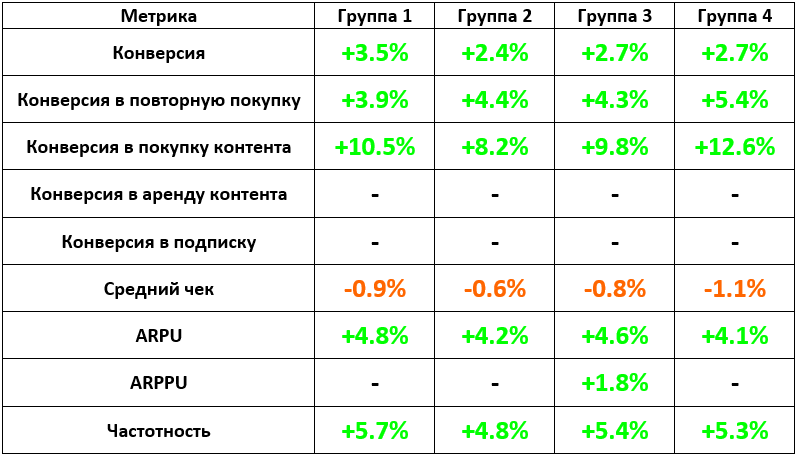

Несмотря на падение среднего чека на 0.6-1% (в зависимости от группы), конверсия и общая выручка в итоге выросли, так же выросли ARPU и ARPPU (только в третьей группе). 
<br>
<br>
То есть **эксперимент прошел успешно**, мы стали зарабатывать больше, привлекая больше новых клиентов к оплате наших услуг, а также увеличивая сумму, которую клиент в общей сложности тратит на нашем сервисе. 
<br>
<br>
Так как средний чек упал, а конверсия, ARPU и ARPPU (в третьей группе) выросли, предполагаем, что платить больше стали за счет увеличения числа платящих пользователей. Это хорошо, так как вовлекается больше пользователей, которые удовлетворены нашим сервисом (на что показывает выросшая конверсия в повторную покупку), увеличивает наши общие доходы и их предсказуемость (мы не держимся только за исключительно лояльных клиентов, а расширяем базу, не теряя в выручке). 
<br>
<br>
ARPU может вырасти исключительно за счет того, что у нас увеличилась конверсия (рост дохода за счет роста новых пользователей), а может за счет того, что пользователи стали покупать больше. Так как у нас выросли и конверсия, и частотность, **отвергаем гипотезу о том, что причина роста ARPU - исключительно в новых пользователях - она еще и в увеличении числа покупок.**

Самой приоритетной метрикой является ARPU, так как она фактически учитывает и кол-во пользователей, и всю сумму, которую мы получаем. Так как ARPU лучше всего отражает эффект платежной активности в сервисе, **рекомендуется распространять на всех пользователей вариант для первой группы**. Именно в ней ARPU вырос больше всего (на 4.8%). При этом конверсия и частотность в этой группе также выросли больше, чем в остальных. При этом надо обратить внимание, что конверсия в повторную покупку в первой группе увеличилась меньше всего. Применяя новую фичу, необходимо следить за удержанием, чтобы не допустить оттока клиентов, обеспечивая прогнозируемый и стабильный заработок

Можно было бы провести более детальный анализ, подсветив несколько важных аспектов, однако для этого недостаточно данных. Рекомендуется собрать следующие данные, чтобы решить некоторые типы задач:
<br>
<br>
1) реальные данных по дате, чтобы посчитать удержание;
<br>
<br>
2) тип подписки (месячная, полугодовая, годовая), чтобы посмотреть динамику конверсий в них; 
<br>
<br>
3) данные по удовлетворенностью новой системы оплаты, чтобы посчитать CSI